In [1]:
%load_ext load_style
%load_style talk.css

# EOF analysis in central pacific ocean

In statistics and signal processing, the method of empirical orthogonal function (EOF) analysis is a decomposition of a signal or data set in terms of orthogonal basis functions which are determined from the data. It is similar to performing a principal components analysis on the data, except that the EOF method finds both temporal projections and spatial patterns. The term is also interchangeable with the geographically weighted PCAs in geophysics (https://en.wikipedia.org/wiki/Empirical_orthogonal_functions).

The spatial patterns are the EOFs, and can be thought of as basis functions in terms of variance. The associated temporal projections are the pricipal components (PCs) and are the temporal coefficients of the EOF patterns.

This notebook is inspired by the [blog](https://podaac.jpl.nasa.gov/forum/viewtopic.php?f=5&t=337) presented by yiboj, where you can download the sample [code](ftp://podaac.jpl.nasa.gov/allData/common/sw/eof/eof_analysis_forum.py) and sample [data](ftp://podaac.jpl.nasa.gov/allData/common/sw/eof/eof_data/). For convinience, yearly data have been converted into a single file using [**CDO**](https://code.mpimet.mpg.de/projects/cdo/wiki). However, it should be noted this notebook simplifies the original source code through some advanced syntaxes of NumPy and fixs a bug of filling zeros over land.

The SST data is from from AVHRR Level 4 dataset in central pacific ocean from 1982 to 2000.

## 1. Load basic libraries

In [2]:
% matplotlib inline

import numpy as np
from scipy import signal
import numpy.polynomial.polynomial as poly
from netCDF4 import Dataset

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from eofs.standard import Eof

## 2. Load SST data

### 2.1 Read SST

In [3]:
startY = 1982
endY   = 2000
ndy    = 36

infile = 'data\eof_data\sst.sw.AVHRR.l4.1982.2000.nc'
ncin = Dataset(infile, 'r')
sst_raw = ncin.variables['analysed_sst'][:]    
lons = ncin.variables['lon'][:] 
lats = ncin.variables['lat'][:] 
ncin.close()

nt,nlat,nlon = sst_raw.shape
ny = nt/ndy
mask = sst_raw.mask

### 2.2 Declare variables

In [4]:
sst_detrend = np.empty(sst_raw.shape)
sst_coeffs  = np.empty((2, nlat, nlon))
sst_detrend[:,:,:] = np.nan

## 3. Detrend

In [5]:
x = np.linspace(1,nt,nt)

for i in range(0, nlat):
  for j in range(0,nlon):
    ytemp = np.copy(sst_raw[:,i,j])
    y = sst_raw[:,i,j]
    b = ~np.isnan(y)
    coefs = poly.polyfit(x[b], y[b], 1)
    sst_coeffs[0,i,j] = coefs[0]
    sst_coeffs[1,i,j] = coefs[1]
    ffit = poly.polyval(x[b], coefs)
    sst_detrend[b,i,j] = y[b] - ffit

## 4. Remove seasonal cycle

### 4.1 Rearrange data for seasonal removal

In [6]:
sst_all = sst_detrend.reshape((ndy,ny,nlat,nlon), order='F').transpose((1,0,2,3)) # year, 36, lat, lon

### 4.2 Calculate seasonal cycle

In [7]:
sst_season = np.mean(sst_all, axis=0)

### 4.3 Remove seasonal cycle

Here utlized the broadcast property of numpy.array

In [8]:
sst_diff = sst_all - sst_season
sst_diff = np.ma.masked_array(sst_diff, mask=mask) # have to do this, or fill in zeros in sst_diff.

### 4.4 Rearrange array to original format

In [9]:
sst_final = sst_diff.transpose((1,0,2,3)).reshape((ndy*ny,nlat,nlon), order='F')

## 5. Carry out EOF analysis

### 5.2 Create an EOF solver to do the EOF analysis

Square-root of cosine of latitude weights are applied before the computation of EOFs. 

In [10]:
coslat = np.cos(np.deg2rad(lats))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_final, weights=wgts)

print(coslat.shape)
print(wgts.shape)

(17L,)
(17L, 1L)


### 5.3 Retrieve the leading EOFs

Expressed as the correlation between the leading PC time series and the input SST anomalies at each grid point, and the
leading PC time series itself.

In [11]:
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

## 6. Visualize leading EOFs

Expressed as correlation in the Pacific domain.

### 6.1 Plot EOFs and PCs

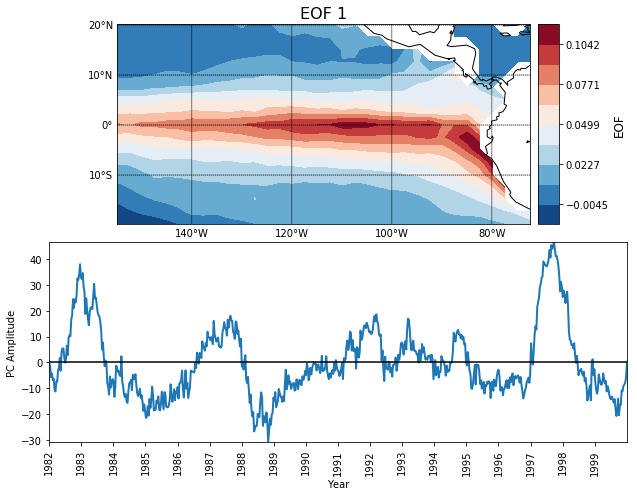

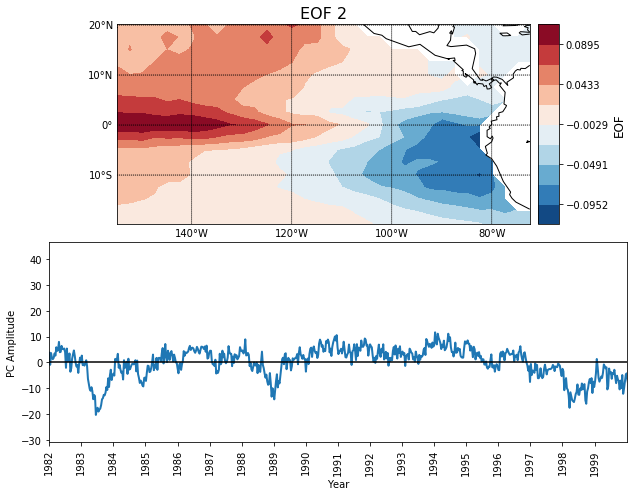

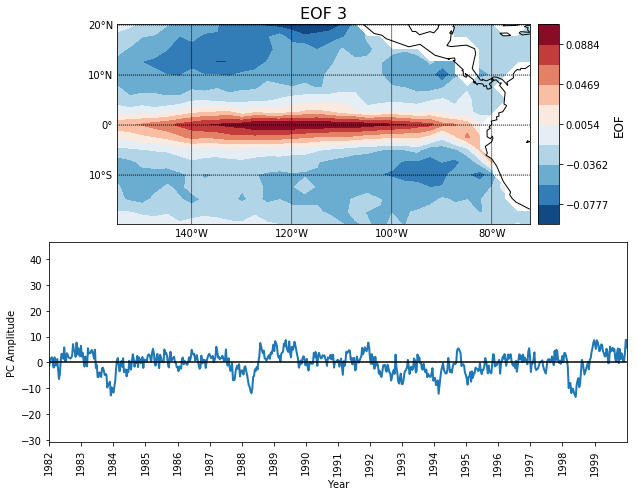

In [12]:
parallels = np.arange(-90,90,10.)
meridians = np.arange(-180,180,20)

for i in range(0, 3):
    fig = plt.figure(figsize=(9,7))
    plt.subplot(211)
    #ax=fig.add_axes([0.1,0.1,0.8,0.8])
    m = Basemap(projection='cyl', llcrnrlon=min(lons), llcrnrlat=min(lats),
        urcrnrlon=max(lons), urcrnrlat=max(lats))
    x, y = m(*np.meshgrid(lons, lats))
    clevs = np.linspace(np.min(eof1[i,:,:].squeeze()), np.max(eof1[i,:,:].squeeze()), 11)
    cs = m.contourf(x, y, eof1[i,:,:].squeeze(), clevs, cmap=plt.cm.RdBu_r)
    m.drawcoastlines()
    #m.fillcontinents(color='#000000',lake_color='#99ffff')
    m.drawparallels(parallels,labels=[1,0,0,0])
    m.drawmeridians(meridians,labels=[1,0,0,1])

    #cb = plt.colorbar(cs, orientation='horizontal')
    cb = m.colorbar(cs, 'right', size='5%', pad='2%')
    cb.set_label('EOF', fontsize=12)
    plt.title('EOF ' + str(i+1), fontsize=16)

    plt.subplot(212)
    days = [startY+(x*10+1)/365.0 for x in range(0, nt)]
    plt.plot(days, pc1[:,i], linewidth=2)
    plt.xticks(range(startY, endY), rotation='vertical')
    plt.axhline(0, color='k')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')
    plt.xlim(startY, endY)
    plt.ylim(np.min(pc1.squeeze()), np.max(pc1.squeeze()))
    plt.xticks(range(startY, endY))
    plt.tight_layout()

### 6.2 Check variances explained by leading EOFs

(2.2025026959719079e-06, 0.47371834810114177)

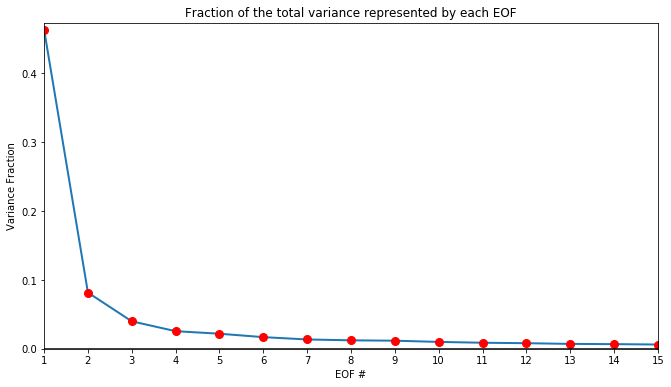

In [13]:
plt.figure(figsize=(11,6))
eof_num = range(1, 16)
plt.plot(eof_num, varfrac[0:15], linewidth=2)
plt.plot(eof_num, varfrac[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

The spatial pattern of this EOF is the canonical El Nino pattern, and
the associated time series shows large peaks and troughs for well-known
El Nino and La Nina events.

## References

http://unidata.github.io/netcdf4-python/

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37